# Experiment Baseline Prediction (Simple rules)
 * For each subject: 
   * select maximal one object based on rules
     * Do not choose relations for subject labels "Application" and "ProgrammingEnvironment"
     * Do not decide for object if direction is not in train data for the subject_label
     * Take nearest candidate object (base on the distance in the text)

In [1]:
import pandas as pd
from sklearn.metrics import classification_report

C:\Users\fschr\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### Read the datasets

In [2]:
train_set = pd.read_json("../../data/subtask3/train_prepro.json")
valid_set = pd.read_json("../../data/subtask3/valid_prepro.json")
test_set = pd.read_json("../../data/subtask3/test_prepro.json")

In [3]:
# For Classification Report
labels = [
    'Version_of',
    'Developer_of',
    'Citation_of',
    'URL_of',
    'PlugIn_of',
    'Specification_of',
    'Release_of',
    'Extension_of',
    'License_of',    
    'Abbreviation_of',
    'AlternativeName_of',
]

# number of objects by subject

In [4]:
train_set.groupby(["sentence_id", "subject_begin"]).apply(len).value_counts()#["object_begin"].value_counts()

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_29908\712645128.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_set.groupby(["sentence_id", "subject_begin"]).apply(len).value_counts()#["object_begin"].value_counts()


1     1333
2      777
3      253
4       66
8       24
5       19
6       13
9       13
7        4
10       3
Name: count, dtype: int64

# Why only one object for each subject

In [5]:
filter_nil = train_set.relation != 'nil'
train_set[filter_nil].groupby(["sentence_id", "subject_begin"]).apply(lambda x: x.object_begin.unique()).apply(len).value_counts()#["object_begin"].value_counts()#.value_counts()

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_29908\3716141065.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_set[filter_nil].groupby(["sentence_id", "subject_begin"]).apply(lambda x: x.object_begin.unique()).apply(len).value_counts()#["object_begin"].value_counts()#.value_counts()


1    1987
2       7
3       1
Name: count, dtype: int64

### observation 
- every subject has only one object in the annotated training corpus
### conclusion
- for every subject we need to select one relation

# But is there any subject that has more than one objects?

In [6]:
train_set[filter_nil]\
    .groupby(["sentence_id", "subject_begin"])\
    .apply(lambda x: x.relation.value_counts())\
    .groupby("relation")\
    .value_counts()

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_29908\3628859130.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.relation.value_counts())\


relation            count
Abbreviation_of     1         51
AlternativeName_of  1         12
Citation_of         1        297
                    2          3
Developer_of        1        484
                    2          4
Extension_of        1         27
License_of          1         28
PlugIn_of           1        125
Release_of          1         59
Specification_of    1         41
URL_of              1        147
                    3          1
Version_of          1        716
Name: count, dtype: int64

### observation
- 'Developer_of', 'Citation_of' and 'URL_of' are the relations, that have subjects with more than one objects

# Can we have subject candidates without relations?

In [7]:
def subject_of_only_nil_relation(object_list):
    # are there only nil relations
    only_nil = all(object_list.relation == "nil")
    if only_nil:
        return object_list.subject_label.iloc[0]

train_set\
    .groupby(["sentence_id", "subject_begin"])\
    .apply(subject_of_only_nil_relation)\
    .value_counts()

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_29908\2536713387.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(subject_of_only_nil_relation)\


Application               415
ProgrammingEnvironment     57
PlugIn                     38
Name: count, dtype: int64

In [8]:
filter_nil = train_set.relation != 'nil'
train_set[filter_nil].groupby("subject_label").relation.value_counts()

subject_label           relation          
Abbreviation            Abbreviation_of        51
AlternativeName         AlternativeName_of     12
Application             Specification_of       36
                        PlugIn_of               1
Citation                Citation_of           303
Developer               Developer_of          492
Extension               Extension_of           27
License                 License_of             28
                        Specification_of        1
PlugIn                  PlugIn_of             124
ProgrammingEnvironment  Specification_of        4
Release                 Release_of             59
URL                     URL_of                150
Version                 Version_of            716
Name: count, dtype: int64

In [9]:
filter_nil = train_set.relation != 'nil'
train_set.groupby(["subject_label", "relation"]).object_label.value_counts()[40:]

subject_label           relation          object_label          
PlugIn                  PlugIn_of         Application                33
                                          PlugIn                      3
                        nil               PlugIn                    159
                                          ProgrammingEnvironment     44
                                          Application                43
ProgrammingEnvironment  Specification_of  ProgrammingEnvironment      4
                        nil               ProgrammingEnvironment     82
Release                 Release_of        Application                35
                                          ProgrammingEnvironment     23
                                          OperatingSystem             1
                        nil               Application                29
                                          ProgrammingEnvironment     12
                                          PlugIn                      7

## Statistics to see, that some relations are only from right_to_left. (object before subject in text)

In [10]:
f = train_set.label_binary == True
train_set[f].groupby("subject_label").left_to_right.value_counts().unstack().fillna(0).astype(int)

left_to_right,False,True
subject_label,,
Abbreviation,51,0
AlternativeName,12,0
Application,36,1
Citation,301,2
Developer,372,120
Extension,26,1
License,29,0
PlugIn,69,55
ProgrammingEnvironment,4,0


In [11]:
def decide_by_rule(rels):
    #return rels.set_index("object_begin")
    rels["prediction_baseline"] = 0
    rels["prediction_label_baseline"] = "nil"
    rel_label = rels.iloc[0].target_label_binary
    subject_label = rels.subject_label.iloc[0]
    if subject_label not in {"Application", "ProgrammingEnvironment"}:
#     if rel_label not in {"Specification_of", "PlugIn_of", "Extension_of"}:
        f = rels.unprobable_relation_direction == False
        if len(rels[f]) > 0:
            index_best = rels[f].sort_values("subject_object_distance").index[0]
            rels.loc[index_best, "prediction_baseline"] = 1
            rels.loc[index_best, "prediction_label_baseline"] = rel_label
    return rels.set_index("object_begin")[["prediction_baseline", "prediction_label_baseline"]]

In [12]:
%%time
cols_for_rules = ["object_begin", "subject_object_distance", "unprobable_relation_direction", "target_label_binary",
                "max_distance_train", "subject_label"
                 ]
pred = train_set.groupby(["sentence_id", "subject_begin"])[cols_for_rules].apply(decide_by_rule)
train_set = train_set.set_index(["sentence_id", "subject_begin", "object_begin"]).join(pred).reset_index()

pred = valid_set.groupby(["sentence_id", "subject_begin"])[cols_for_rules].apply(decide_by_rule)
valid_set = valid_set.set_index(["sentence_id", "subject_begin", "object_begin"]).join(pred).reset_index()

pred = test_set.groupby(["sentence_id", "subject_begin"])[cols_for_rules].apply(decide_by_rule)
test_set = test_set.set_index(["sentence_id", "subject_begin", "object_begin"]).join(pred).reset_index()

CPU times: total: 12.1 s
Wall time: 12.2 s


## Baseline on train

In [13]:
pd.DataFrame(classification_report(train_set.relation, train_set.prediction_label_baseline, zero_division=0., labels=labels, output_dict=True)).T

,precision,recall,f1-score,support
Version_of,0.962238,0.960894,0.961565,716.0
Developer_of,0.897541,0.890244,0.893878,492.0
Citation_of,0.942953,0.927393,0.935108,303.0
URL_of,0.777027,0.766667,0.771812,150.0
PlugIn_of,0.592593,0.768000,0.668990,125.0
Specification_of,0.000000,0.000000,0.000000,41.0
Release_of,0.932203,0.932203,0.932203,59.0
Extension_of,1.000000,1.000000,1.000000,27.0
License_of,0.862069,0.892857,0.877193,28.0
Abbreviation_of,1.000000,1.000000,1.000000,51.0


## Baseline on validation

In [14]:
pd.DataFrame(classification_report(valid_set.relation, valid_set.prediction_label_baseline, zero_division=0., labels=labels, output_dict=True)).T

,precision,recall,f1-score,support
Version_of,0.963563,0.963563,0.963563,247.0
Developer_of,0.935294,0.913793,0.924419,174.0
Citation_of,0.933333,0.913043,0.923077,92.0
URL_of,0.704918,0.704918,0.704918,61.0
PlugIn_of,0.595238,0.892857,0.714286,28.0
Specification_of,0.000000,0.000000,0.000000,18.0
Release_of,1.000000,1.000000,1.000000,16.0
Extension_of,1.000000,1.000000,1.000000,13.0
License_of,0.800000,0.800000,0.800000,10.0
Abbreviation_of,1.000000,1.000000,1.000000,6.0


## Baseline on test

In [15]:
test_output = pd.DataFrame(classification_report(test_set.relation, test_set.prediction_label_baseline, zero_division=0., labels=labels, output_dict=True)).T

In [16]:
test_output

,precision,recall,f1-score,support
Version_of,0.954128,0.954128,0.954128,109.0
Developer_of,0.879518,0.879518,0.879518,83.0
Citation_of,0.977778,0.977778,0.977778,45.0
URL_of,0.666667,0.666667,0.666667,39.0
PlugIn_of,0.500000,0.923077,0.648649,13.0
Specification_of,0.000000,0.000000,0.000000,8.0
Release_of,0.857143,0.857143,0.857143,7.0
Extension_of,1.000000,0.909091,0.952381,11.0
License_of,0.700000,0.777778,0.736842,9.0
Abbreviation_of,1.000000,1.000000,1.000000,5.0


In [17]:
test_output = test_output.iloc[:-3]

<Figure size 1400x800 with 0 Axes>

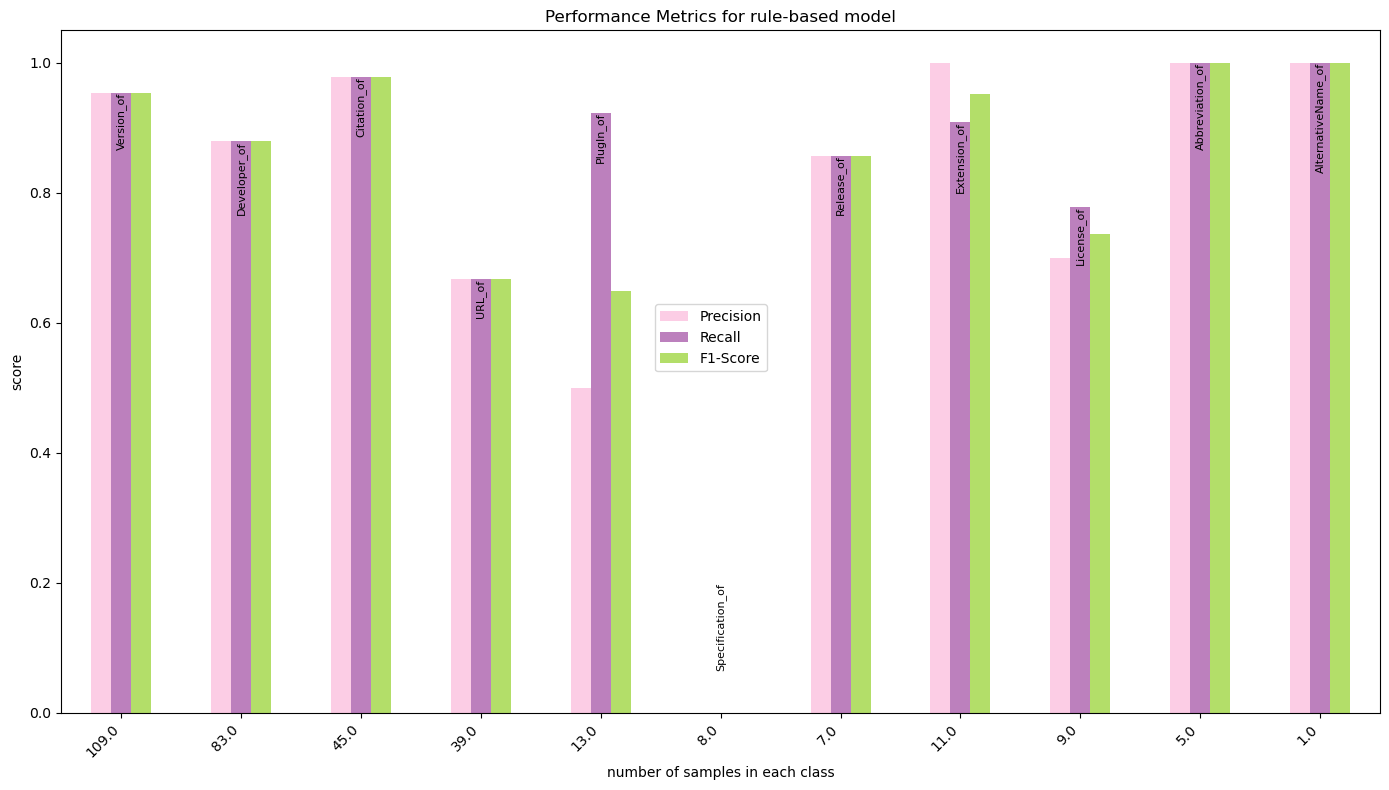

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
colors = sns.color_palette('Set3')
colors_list = [colors[7], colors[9], colors[6]]
# Set the size of the plot
plt.figure(figsize=(14, 8))

# Plotting the precision, recall, and f1-score
ax = test_output.plot(kind='bar', x='support', y=['precision', 'recall', 'f1-score'], color=colors_list, figsize=(14, 8))

# Adding title and labels
plt.title('Performance Metrics for rule-based model')
plt.xlabel('number of samples in each class')
plt.ylabel('score')
# Annotate class names on the middle bar of each class group
for i in range(len(test_output)):
    p = ax.containers[1][i]  # Select the middle bar in each group
    class_name = test_output.index[i]  # Get the class name for the current group
    ax.text(x=p.get_x() + p.get_width() / 2, 
            y=p.get_height() if p.get_height() != 0 else 0.2 ,  # Position slightly above the bar#+ 0.02
            s=class_name, 
            ha='center', va='top', rotation=90, fontsize=8, color='black')
# Rotating the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.legend(['Precision', 'Recall', 'F1-Score'], loc=(0.45, 0.5))
# Show the plot
plt.tight_layout()
plt.show()

In [43]:
test_output

,precision,recall,f1-score,support
Version_of,0.954128,0.954128,0.954128,109.0
Developer_of,0.879518,0.879518,0.879518,83.0
Citation_of,0.977778,0.977778,0.977778,45.0
URL_of,0.666667,0.666667,0.666667,39.0
PlugIn_of,0.500000,0.923077,0.648649,13.0
Specification_of,0.000000,0.000000,0.000000,8.0
Release_of,0.857143,0.857143,0.857143,7.0
Extension_of,1.000000,0.909091,0.952381,11.0
License_of,0.700000,0.777778,0.736842,9.0
Abbreviation_of,1.000000,1.000000,1.000000,5.0


In [22]:
output = test_output.loc['weighted avg'].drop('support').to_dict()

In [23]:
output['name'] = 'rule based'

In [24]:
output

{'precision': 0.856969696969697,
 'recall': 0.8727272727272727,
 'f1-score': 0.8622430359272466,
 'name': 'rule based'}

In [26]:
import json
with open("subtask3_results.txt", "a") as myfile:
    myfile.write(json.dumps(output) + "\n")